In [1]:
#필요한 라이브러리 불러기기 및 텐서플로우 버전 확인
import os
import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
print(tf.__version__)
! python -V

2.10.0
Python 3.10.13


In [2]:
# GPU 사용을 위한 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus) > 0:
    try:
        # GPU 메모리 할당 제한 (적절히 설정 가능)
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])  # 예시: 4GB 할당
        print("GPU 메모리 설정 완료")
    except RuntimeError as e:
        print(e)
else:
    print("GPU 사용 불가")

GPU 메모리 설정 완료


In [3]:
#GPU 사용 가능할 때만 돌리는 코드
import os
import tensorflow as tf
from tensorflow.python.client import device_lib
os.environ["CUDA_VISIBLE_DEVICES"] = "0" #GPU 할당
print(device_lib.list_local_devices()) #CPU, GPU 리스트 보는 법

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 681650804409355376
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6948913152
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9542204880425981006
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


In [4]:
#GPU에 대한 내용 확인 시 사용하는 코드
!nvidia-smi

Thu Dec  5 02:11:54 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1070      WDDM  |   00000000:01:00.0  On |                  N/A |
| 30%   29C    P2             33W /  150W |     472MiB /   8192MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
# GPU 사용 가능 여부 확인
print(tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [71]:
# mnist data 불러와서 학습 및 테스트로 분할 
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 데이터셋 크기 확인
print(f"학습 데이터 개수: {x_train.shape[0]}")  # 학습 데이터 개수
print(f"테스트 데이터 개수: {x_test.shape[0]}")  # 테스트 데이터 개수
print(f"전체 데이터 개수: {x_train.shape[0] + x_test.shape[0]}")  # 전체 데이터 개수

학습 데이터 개수: 60000
테스트 데이터 개수: 10000
전체 데이터 개수: 70000


In [7]:
# 불러온 데이터 중 NAN 값 있는지 확인
print(np.isnan(x_train).any())
print(np.isnan(y_train).any())
print(np.isnan(x_test).any())
print(np.isnan(y_test).any())

False
False
False
False


In [8]:
# 불러온 데이터를 학습하기 위해 
input_shape = (28, 28, 1)
x_train=x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_train=x_train / 255.0
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
x_test=x_test/255.0

In [9]:
# one-hot 인코딩을 사용해 라벨 값을 이진 벡터로 표현
y_train = tf.one_hot(y_train.astype(np.int32), depth=10)
y_test = tf.one_hot(y_test.astype(np.int32), depth=10)

tf.Tensor([0. 0. 0. 0. 0. 1. 0. 0. 0. 0.], shape=(10,), dtype=float32)


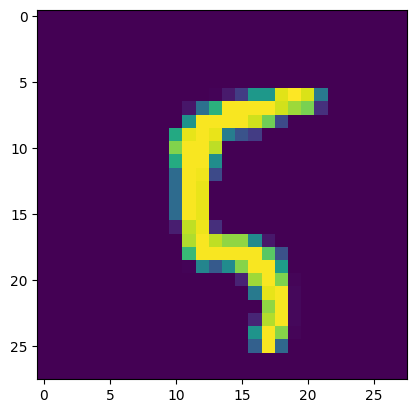

In [10]:
# 변환 후 결과확인 
plt.imshow(x_train[100][:,:,0])
print(y_train[100])

In [11]:
# 모델 학습 파라미터 결정
##부분 값을 채우세요
batch_size = 512
num_classes = 10
epochs = 20

In [13]:
# 모델 계계
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu', input_shape=input_shape),
    tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(strides=(2,2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(epsilon=1e-08), loss='categorical_crossentropy', metrics=['acc'])

In [14]:
# 모델의 call back 클래스 설정
#threshold 값을 채우세요.
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.99):
      print("\nReached (threshold)% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [15]:
#모델 학습
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.1,
                    callbacks=[callbacks])

Epoch 1/20
106/106 [==============================] - 37s 41ms/step - loss: 0.4927 - acc: 0.8430 - val_loss: 0.0765 - val_acc: 0.9767
Epoch 2/20
106/106 [==============================] - 4s 35ms/step - loss: 0.1264 - acc: 0.9634 - val_loss: 0.0546 - val_acc: 0.9852
Epoch 3/20
106/106 [==============================] - 4s 35ms/step - loss: 0.0830 - acc: 0.9760 - val_loss: 0.0550 - val_acc: 0.9840
Epoch 4/20
106/106 [==============================] - 4s 35ms/step - loss: 0.0653 - acc: 0.9799 - val_loss: 0.0362 - val_acc: 0.9898
Epoch 5/20
106/106 [==============================] - 4s 35ms/step - loss: 0.0544 - acc: 0.9838 - val_loss: 0.0270 - val_acc: 0.9923
Epoch 6/20
106/106 [==============================] - 4s 35ms/step - loss: 0.0477 - acc: 0.9856 - val_loss: 0.0278 - val_acc: 0.9933
Epoch 7/20
106/106 [==============================] - 4s 35ms/step - loss: 0.0411 - acc: 0.9874 - val_loss: 0.0250 - val_acc: 0.9932
Epoch 8/20
106/106 [==============================] - 4s 35ms/step -

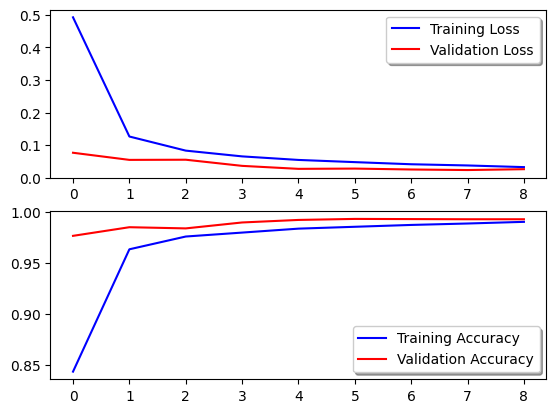

In [16]:
# 학습 결과 그래프로 표현
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training Loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation Loss")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training Accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)
plt.savefig("training_result.png")
plt.show()

In [17]:
# 테스트 데이터 셋을 통해 모델 성능 평가
test_loss, test_acc = model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.0211 - acc: 0.9938


In [18]:
# 테스트 데이터 셋으로 예측
Y_pred = model.predict(x_test)
# 예측 결과를 one-hot 인코딩으로 이진 벡터로 변환
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# 정답 값을 one-hot 인코딩으로 이진 벡터로 변환
Y_true = np.argmax(y_test,axis = 1)
# 혼돈 매트릭스 계산
confusion_mtx = tf.math.confusion_matrix(Y_true, Y_pred_classes) 

313/313 [==============================] - 1s 2ms/step


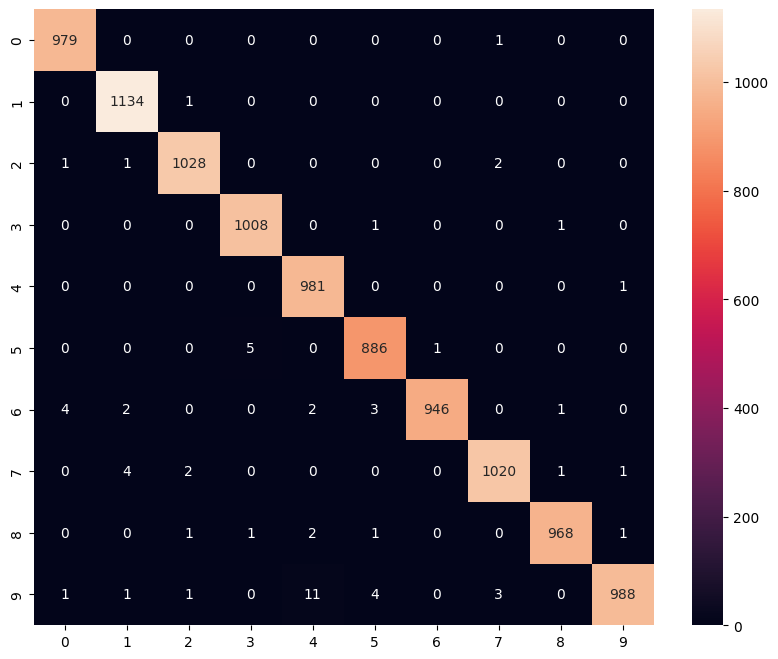

In [19]:
#혼돈 매트릭스 그래프로 그기기
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='g')
plt.savefig("confusion.png")

Original image size: (113, 106), Mode: RGB


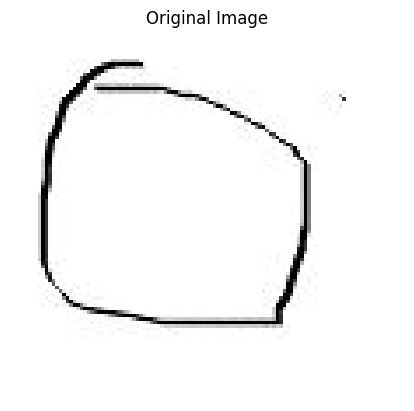

In [92]:
from PIL import Image, ImageOps, ImageEnhance
import numpy as np

# 이미지를 불러와서 크기 출력
image_path = './ipad_image/0.jpg'  # 실제 이미지 경로로 변경
img = Image.open(image_path)
print(f"Original image size: {img.size}, Mode: {img.mode}")

# 원본 이미지 출력
plt.imshow(img, cmap='gray' if img.mode == 'L' else None)  # 흑백이면 cmap='gray'로 설정
plt.title('Original Image')  # 제목 설정
plt.axis('off')  # 축 숨기기
plt.show()

Original image size: (113, 106), Mode: RGB
Resizing image to 28x28. Original size: (113, 106)


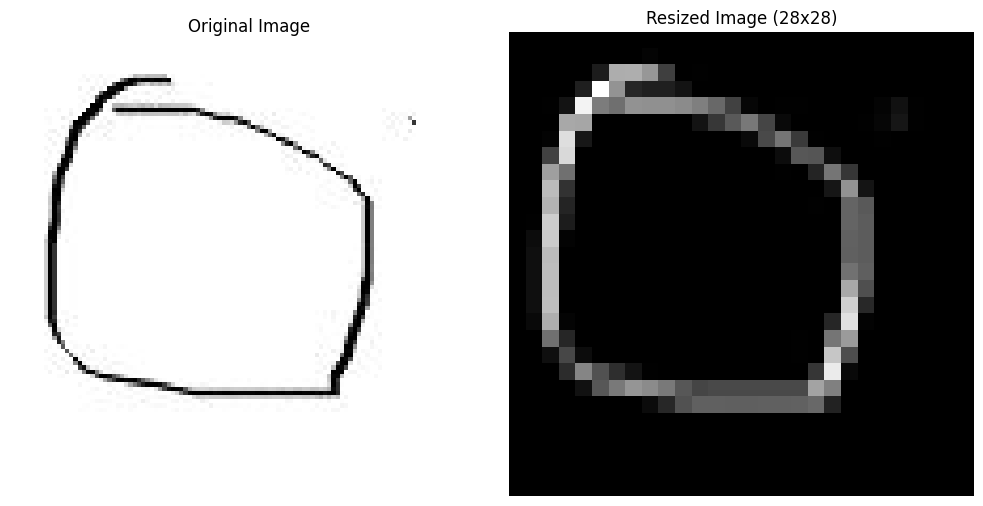

1/1 [==============================] - 0s 20ms/step
예측된 숫자: 2


In [93]:
# 1. 직접 촬영한 이미지를 불러와서 전처리하는 함수
def preprocess_image(image_path):
    # 이미지 불러오기
    img = Image.open(image_path)
    
    # 이미지 크기 및 채널 확인 (디버깅용)
    print(f"Original image size: {img.size}, Mode: {img.mode}")
    
    # 흑백 이미지로 변환 ('L' 모드)
    img_gray = img.convert('L')  # 'L'은 흑백 이미지로 변환
    
    # 이미지 반전: MNIST와 동일하게 글씨가 흰색, 배경이 검정색으로 변환
    img_inverted = ImageOps.invert(img_gray)  # 색 반전
    
    # 리사이즈 전에 크기 확인
    print(f"Resizing image to 28x28. Original size: {img_inverted.size}")
    
    # 원본 이미지를 28x28 크기로 리사이즈
    img_resized = img_inverted.resize((28, 28))  # MNIST 이미지 크기인 28x28로 리사이즈
    
    # 이미지를 numpy 배열로 변환
    img_array = np.array(img_resized)  # 리사이즈된 이미지 배열로 변환
    
    # 모델 입력에 맞게 형태 변경
    img_normalized = img_array.reshape(28, 28, 1)  # (28, 28, 1)로 변환
    img_normalized = img_normalized / 255.0  # 정규화
    
    # 배치 차원 추가
    img_normalized = np.expand_dims(img_normalized, axis=0)  # 배치 차원 추가
    
    return img, img_normalized  # RGB 원본 이미지와 전처리된 이미지를 반환

# 3. 이미지를 전처리하여 모델에 입력 가능한 형태로 변환
img_original, processed_image = preprocess_image(image_path)

# 4. 원본 이미지와 리사이즈된 이미지를 한 화면에 표시
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1x2 그리드로 서브플롯 생성

# 원본 이미지 출력
axes[0].imshow(img_original, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')  # 축 숨기기

# 리사이즈된 이미지 출력 (배치 차원 제거)
axes[1].imshow(processed_image.squeeze(), cmap='gray')  # 배치 차원 제거하고 표시
axes[1].set_title('Resized Image (28x28)')
axes[1].axis('off')  # 축 숨기기

plt.tight_layout()
plt.show()

# 5. 모델을 사용하여 예측
predicted_probabilities = model.predict(processed_image)
predicted_class = np.argmax(predicted_probabilities, axis=1)

# 6. 예측 결과 출력
print(f"예측된 숫자: {predicted_class[0]}")

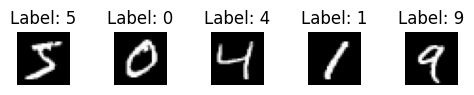

In [43]:
import matplotlib.pyplot as plt

def display_sample_images(x_data, y_data, num_samples=10):
    """
    학습 데이터에서 샘플 이미지를 출력하는 함수.

    Parameters:
        x_data (numpy array): 입력 이미지 데이터 (예: x_train)
        y_data (numpy array): 라벨 데이터 (예: y_train)
        num_samples (int): 출력할 샘플 이미지 수 (기본값: 10)
    """
    plt.figure(figsize=(5, 1))  # 전체 플롯 크기 설정
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)  # 1행 num_samples열의 서브플롯 생성
        plt.imshow(x_data[i].squeeze(), cmap='gray')  # 이미지 출력 (채널 제거 후)
        plt.title(f"Label: {np.argmax(y_data[i])}")  # 라벨 출력 (원-핫 인코딩 기준)
        plt.axis('off')  # 축 숨기기
    plt.tight_layout()
    plt.show()

# 사용 예시
display_sample_images(x_train, y_train, num_samples=5)
